In [34]:
# Importing Necessary Libraries 

import os
import platform
import shutil
from IPython.display import clear_output

print(platform.platform())

def resolve_dir(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)

def reset_path(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)
    else:
        shutil.rmtree(Dir)
        os.mkdir(Dir)

Windows-10-10.0.22631-SP0


In [35]:
import tensorflow as tf
tf.random.set_seed(73)
TPU_INIT = False

if TPU_INIT:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
        tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime!')
else:
    !nvidia-smi
;    
print("Tensorflow version " + tf.__version__)

Sat Feb 24 16:57:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.26                 Driver Version: 546.26       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2050      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   52C    P3               7W /  30W |      0MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [36]:
# Directory

PROJECT_DIR = r'C:\Users\rajiv\OneDrive\Desktop\Real Life Violence Dataset'


In [37]:
# Python function that takes a video file as input, encodes it in base64 format, embeds it into an HTML video element

from IPython.display import HTML
from base64 import b64encode

def play(filename):
    html = ''
    video = open(filename,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/mp4"></video>' % src 
    return HTML(html)

In [38]:
# Playing Video From Violence file 

play(r'C:\Users\rajiv\OneDrive\Desktop\Real Life Violence Dataset\Violence\V_81.mp4')

In [39]:
# Playing Video from non violence file 

play(r'C:\Users\rajiv\OneDrive\Desktop/Real Life Violence Dataset/NonViolence/NV_313.mp4')

# Taking video files and converting into list of augmented images  

In [40]:
import cv2
import os
import imageio
import imgaug.augmenters as iaa
import imgaug as ia

IMG_SIZE = 128
ColorChannels = 3

def video_to_frames(video):
    vidcap = cv2.VideoCapture(video)
    
    import math
    rate = math.floor(vidcap.get(3))
    count = 0
    
    ImageFrames = []
    while vidcap.isOpened():
        ID = vidcap.get(1)
        success, image = vidcap.read()
        if success:
            # skipping frames to avoid duplications 
            if (ID % 7 == 0):
                flip = iaa.Fliplr(1.0)
                zoom = iaa.Affine(scale=1.3)
                random_brightness = iaa.Multiply((1, 1.3))
                rotate = iaa.Affine(rotate=(-25, 25))
                
                image_aug = flip(image = image)
                image_aug = random_brightness(image = image_aug)
                image_aug = zoom(image = image_aug)
                image_aug = rotate(image = image_aug)
                
                rgb_img = cv2.cvtColor(image_aug, cv2.COLOR_BGR2RGB)
                resized = cv2.resize(rgb_img, (IMG_SIZE, IMG_SIZE))
                ImageFrames.append(resized)
                
            count += 1
        else:
            break
    
    vidcap.release()
    
    return ImageFrames

 # Extracting frames from each video and storing them with their corresponding labels in lists

In [41]:
from tqdm import tqdm

VideoDataDir = os.path.join(PROJECT_DIR)
print('We have \n{} Violence videos \n{} NonViolence videos'.format(
    len(os.listdir(os.path.join(VideoDataDir, 'Violence'))), 
    len(os.listdir(os.path.join(VideoDataDir, 'NonViolence')))
))

X_original = []
y_original = []

print('I choose 700 videos out of 2000, due to memory issues')
CLASSES = ["NonViolence", "Violence"]
# 700 <- 350 + 350

for category in os.listdir(VideoDataDir):
    path = os.path.join(VideoDataDir, category)
    if os.path.isdir(path):
        class_num = CLASSES.index(category)
        for i, video in enumerate(tqdm(os.listdir(path)[:250])):
            frames = video_to_frames(os.path.join(path, video))
            for j, frame in enumerate(frames):
                X_original.append(frame)
                y_original.append(class_num)


We have 
1000 Violence videos 
1000 NonViolence videos
I choose 700 videos out of 2000, due to memory issues


100%|██████████| 250/250 [01:06<00:00,  3.75it/s]


In [42]:
import numpy as np
X_original = np.array(X_original).reshape(-1 , IMG_SIZE * IMG_SIZE * 3)
y_original = np.array(y_original)
len(X_original)

9990

# spliting  data into training and testing 

In [43]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

# Convert them to numpy arrays
X_original = np.array(X_original)
y_original = np.array(y_original)

# Check the shapes of X_original and y_original
print(X_original.shape)
print(y_original.shape)

stratified_sample = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=73)

for train_index, test_index in stratified_sample.split(X_original, y_original):
    print(type(train_index))
    print(type(test_index))
    print(train_index.shape)
    print(test_index.shape)
    
    X_train, X_test = X_original[train_index], X_original[test_index]
    y_train, y_test = y_original[train_index], y_original[test_index]

X_train_nn = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255
X_test_nn = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255


(9990, 49152)
(9990,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(6993,)
(2997,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(6993,)
(2997,)


In [44]:
import cv2
import os
import numpy as np
import pickle
import matplotlib
matplotlib.use("Agg")

from keras.layers import Input, Dropout, Flatten, Dense
from keras.models import Model

import matplotlib.pyplot as plt


In [45]:
epochs = 20

from keras import regularizers
kernel_regularizer = regularizers.l2(0.0001)

from keras.applications import MobileNetV2

def load_layers():
    input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, ColorChannels))
    baseModel = MobileNetV2(pooling='avg',
                            include_top=False, 
                            input_tensor=input_tensor)
    
    headModel = baseModel.output   
    headModel = Dense(1, activation="sigmoid")(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)

    for layer in baseModel.layers:
        layer.trainable = False

    print("Compiling model...")
    model.compile(loss="binary_crossentropy",
                    optimizer='adam',
                    metrics=["accuracy"])

    return model

if TPU_INIT:
    with tpu_strategy.scope():
        model = load_layers()
else:
    model = load_layers()

model.summary()

Compiling model...
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_

 rmalization)                                                                                     
                                                                                                  
 block_3_expand_relu (ReLU)  (None, 32, 32, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 33, 33, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 16, 16, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_d

 seConv2D)                                                                                        
                                                                                                  
 block_6_depthwise_BN (Batc  (None, 8, 8, 192)            768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 8, 8, 192)            0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 8, 8, 64)             12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
          

 block_9_project_BN (BatchN  (None, 8, 8, 64)             256       ['block_9_project[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_9_add (Add)           (None, 8, 8, 64)             0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 8, 8, 384)            24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 8, 8, 384)            1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
          

 block_13_expand_BN (BatchN  (None, 8, 8, 576)            2304      ['block_13_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_13_expand_relu (ReLU  (None, 8, 8, 576)            0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 9, 9, 576)            0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 4, 4, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D

                                                                                                  
 block_16_depthwise (Depthw  (None, 4, 4, 960)            8640      ['block_16_expand_relu[0][0]']
 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 4, 4, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 4, 4, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_

In [46]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

patience = 3

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005

batch_size = 4

if TPU_INIT:
    max_lr = max_lr * tpu_strategy.num_replicas_in_sync
    batch_size = batch_size * tpu_strategy.num_replicas_in_sync

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if ((logs.get('accuracy')>=0.999)):
            print("\nLimits Reached cancelling training!")
            self.model.stop_training = True

In [47]:
end_callback = myCallback()

lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

early_stopping = EarlyStopping(patience = patience, monitor='val_loss',
                                 mode='min', restore_best_weights=True, 
                                 verbose = 1, min_delta = .00075)

PROJECT_DIR = r'C:\Users\rajiv\OneDrive\Desktop\Real Life Violence Dataset'

lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')

os.system('rm -rf ./logs/')

import datetime
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir = log_dir, write_graph=True, histogram_freq=1)

checkpoint_filepath = 'ModelWeights.h5'
model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)


callbacks = [end_callback, lr_callback, model_checkpoints, tensorboard_callback, early_stopping, lr_plat]

if TPU_INIT:
    callbacks = [end_callback, lr_callback, model_checkpoints, early_stopping, lr_plat]

In [48]:
print('Training head...')
#model.load_weights('./Model_Weights.h5')

history = model.fit(X_train_nn ,y_train, epochs=epochs,
                        callbacks=callbacks,
                        validation_data = (X_test_nn, y_test),
                        batch_size=batch_size)

print('\nRestoring best Weights for MobileNetV2')
model.load_weights(checkpoint_filepath)

Training head...
Epoch 1/20
1748/1749 [============================>.] - ETA: 0s - loss: 0.7633 - accuracy: 0.5818
Epoch 1: val_loss improved from inf to 0.65555, saving model to ModelWeights.h5
1749/1749 [==============================] - 53s 28ms/step - loss: 0.7633 - accuracy: 0.5819 - val_loss: 0.6556 - val_accuracy: 0.6527 - lr: 1.0000e-05
Epoch 2/20
1747/1749 [============================>.] - ETA: 0s - loss: 0.5470 - accuracy: 0.7220
Epoch 2: val_loss improved from 0.65555 to 0.45573, saving model to ModelWeights.h5
1749/1749 [==============================] - 46s 26ms/step - loss: 0.5468 - accuracy: 0.7222 - val_loss: 0.4557 - val_accuracy: 0.7901 - lr: 1.8000e-05
Epoch 3/20
1748/1749 [============================>.] - ETA: 0s - loss: 0.3889 - accuracy: 0.8340
Epoch 3: val_loss improved from 0.45573 to 0.33419, saving model to ModelWeights.h5
1749/1749 [==============================] - 46s 26ms/step - loss: 0.3890 - accuracy: 0.8338 - val_loss: 0.3342 - val_accuracy: 0.8649 - 

In [49]:
%matplotlib inline

def print_graph(item, index, history):
    plt.figure()
    train_values = history.history[item][0:index]
    plt.plot(train_values)
    test_values = history.history['val_' + item][0:index]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)


def get_best_epoch(test_loss, history):
    for key, item in enumerate(history.history.items()):
        (name, arr) = item
        if name == 'val_loss':
            for i in range(len(arr)):
                if round(test_loss, 2) == round(arr[i], 2):
                    return i
                
def model_summary(model, history):
    print('---'*30)
    test_loss, test_accuracy = model.evaluate(X_test_nn, y_test, verbose=0)

    if history:
        index = get_best_epoch(test_loss, history)
        print('Best Epochs: ', index)

        train_accuracy = history.history['accuracy'][index]
        train_loss = history.history['loss'][index]

        print('Accuracy on train:',train_accuracy,'\tLoss on train:',train_loss)
        print('Accuracy on test:',test_accuracy,'\tLoss on test:',test_loss)
        print_graph('loss', index, history)
        print_graph('accuracy', index, history)
        print('---'*30)  

------------------------------------------------------------------------------------------
Best Epochs:  19
Accuracy on train: 0.9642499685287476 	Loss on train: 0.11454019695520401
Accuracy on test: 0.9539539813995361 	Loss on test: 0.13461314141750336


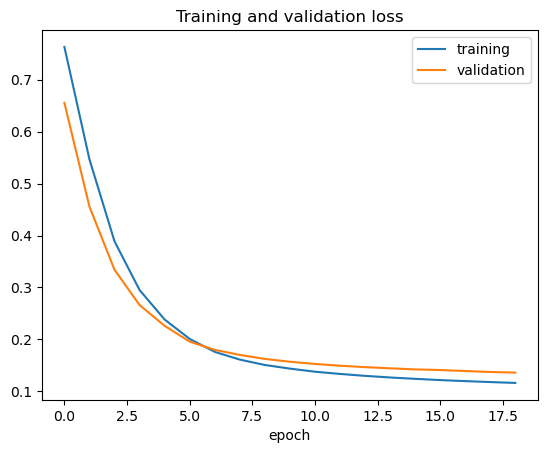

<Figure size 640x480 with 0 Axes>

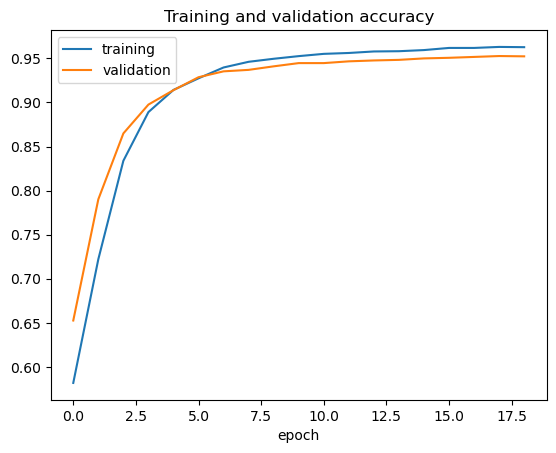

------------------------------------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

In [50]:
model_summary(model, history)

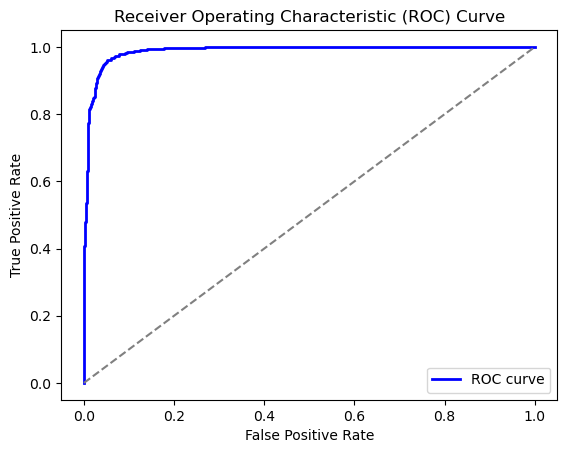

In [52]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, predictions)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [53]:
args_model = "model.h5"
model.save(args_model)

D:\Anaconda_installation\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [55]:
import numpy as np
import argparse
import pickle
import cv2
import os
import time
from keras.models import load_model
from collections import deque

def print_results(video, limit=None):
        fig=plt.figure(figsize=(16, 30))
        if not os.path.exists('output'):
            os.mkdir('output')

        print("Loading model ...")
        model = load_model('./model.h5')
        Q = deque(maxlen=128)
        vs = cv2.VideoCapture(video)
        writer = None
        (W, H) = (None, None)
        count = 0     
        while True:
                (grabbed, frame) = vs.read()
                ID = vs.get(1)
                if not grabbed:
                    break
                try:
                    if (ID % 7 == 0):
                        count = count + 1
                        n_frames = len(frame)
                        
                        if W is None or H is None:
                            (H, W) = frame.shape[:2]

                        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        output = cv2.resize(frame, (512, 360)).copy()
                        frame = cv2.resize(frame, (128, 128)).astype("float32")
                        frame = frame.reshape(IMG_SIZE, IMG_SIZE, 3) / 255
                        preds = model.predict(np.expand_dims(frame, axis=0))[0]
                        Q.append(preds)

                        results = np.array(Q).mean(axis=0)
                        i = (preds > 0.56)[0] #np.argmax(results)

                        label = i

                        text = "Violence: {}".format(label)
                        #print('prediction:', text)
                        file = open("output.txt",'w')
                        file.write(text)
                        file.close()

                        color = (0, 255, 0)
                        if label:
                            color = (255, 0, 0) 
                        else:
                            color = (0, 255, 0)

                        cv2.putText(output, text, (35, 50), cv2.FONT_HERSHEY_SIMPLEX,
                                1, color, 3)


                        # saving mp4 with labels but cv2.imshow is not working with this notebook
                        if writer is None:
                                fourcc = cv2.VideoWriter_fourcc(*"MJPG")
                                writer = cv2.VideoWriter("output.mp4", fourcc, 60,
                                        (W, H), True)

                        writer.write(output)
                        #cv2.imshow("Output", output)

                        fig.add_subplot(8, 3, count)
                        plt.imshow(output)
                        
                    if limit and count > limit:
                        break

                except:
                    break 
        
        plt.show()
        print("Cleaning up...")
        if writer is not None:
            writer.release()
        vs.release()

Loading model ...
1/1 [==============================] - 0s 62ms/step


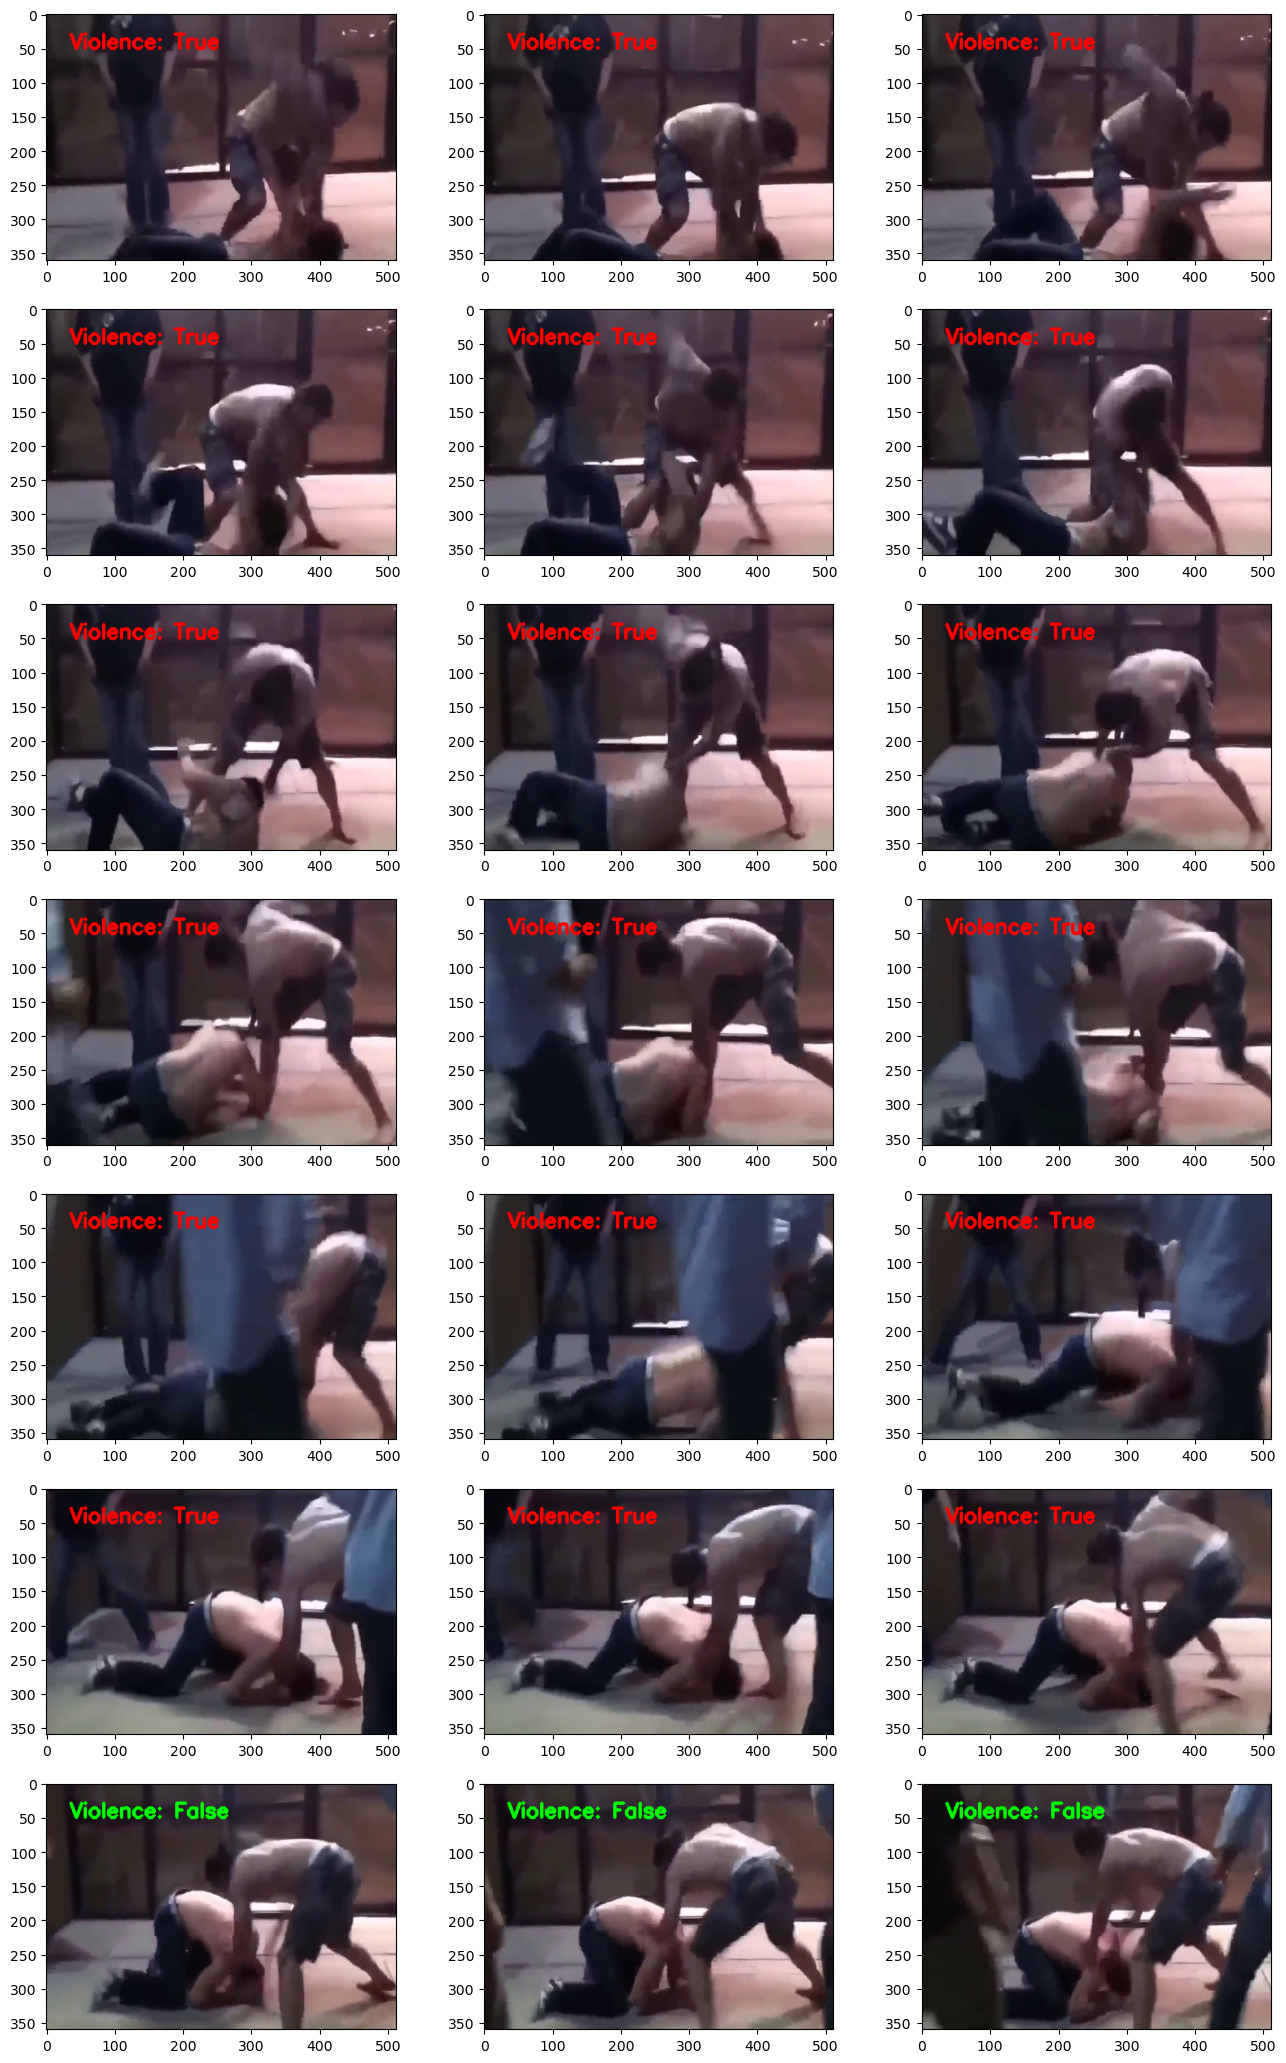

Cleaning up...


In [56]:
Violence=r'C:\Users\rajiv\OneDrive\Desktop\Real Life Violence Dataset\Violence\V_81.mp4' 
print_results(Violence, limit=30)

Loading model ...
1/1 [==============================] - 0s 47ms/step


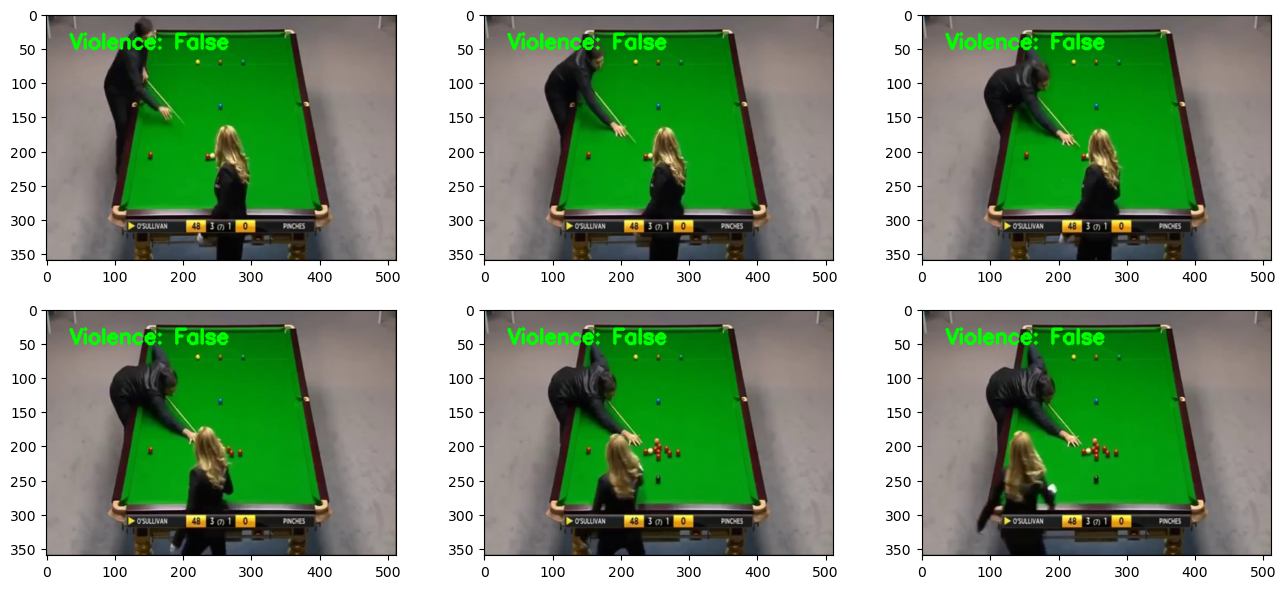

Cleaning up...


In [57]:
NonViolence=r'C:\Users\rajiv\OneDrive\Desktop/Real Life Violence Dataset/NonViolence/NV_313.mp4'
print_results(NonViolence, limit=5)